In [3]:
%cd /Users/oscarmauriciomoraarroyo/proyecto_lyapunov_chagas

/Users/oscarmauriciomoraarroyo/proyecto_lyapunov_chagas


/Users/oscarmauriciomoraarroyo/proyecto_lyapunov_chagas/.venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Calibración del modelo SEIR para enfermedad de Chagas en Valledupar (Cesar)

En este cuaderno se lleva a cabo la calibración de un modelo epidemiológico de tipo SEIR con migración e incidencia no lineal, utilizando como referencia la serie de casos notificados de enfermedad de Chagas en Valledupar (Cesar) durante 2024.

Los objetivos de este cuaderno son:

1. Comparar la serie observada de casos con una simulación base del modelo SEIR.
2. Definir y evaluar una medida de error entre datos reales y modelo (RMSE).
3. Ajustar parámetros seleccionados del modelo (β, c, N₀) mediante optimización numérica.
4. Analizar la calidad del ajuste del modelo SEIR calibrado frente a la serie real.

Los parámetros óptimos obtenidos aquí se emplearán posteriormente para el análisis de estabilidad del sistema mediante el cálculo del exponente de Lyapunov.

## 1. Carga de datos reales y simulados

En primer lugar se cargan:

- La serie de casos observados de Chagas en Valledupar, a partir del archivo `chagas_prepared.csv`.
- La simulación base del modelo SEIR, almacenada en `reports/seir_simulation.csv`.

A partir de estos insumos se construirá una comparación inicial entre datos reales y simulados.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Serie real del foco (Valledupar)
agg_path = "data/clean/chagas_prepared.csv"
agg = pd.read_csv(agg_path)

DEP = "CESAR"
MPIO = "VALLEDUPAR"

real = (
    agg[
        (agg["Departamento_residencia"] == DEP)
        & (agg["Municipio_residencia"] == MPIO)
    ]
    .copy()
    .sort_values(["ANO", "SEMANA"])
)

real.head()

,ANO,SEMANA,Fecha,Departamento_residencia,Municipio_residencia,casos
10,2024,1,2024-01-01,CESAR,VALLEDUPAR,2
66,2024,4,2024-01-22,CESAR,VALLEDUPAR,1
110,2024,7,2024-02-12,CESAR,VALLEDUPAR,6
132,2024,9,2024-02-26,CESAR,VALLEDUPAR,1
146,2024,10,2024-03-04,CESAR,VALLEDUPAR,1


In [5]:
real["fecha"] = pd.to_datetime(
    real["ANO"].astype(str) + real["SEMANA"].astype(str) + "1",
    format="%G%V%u",
)

real_ts = real[["fecha", "casos"]].sort_values("fecha").reset_index(drop=True)
real_ts.head()

,fecha,casos
0,2024-01-01,2
1,2024-01-22,1
2,2024-02-12,6
3,2024-02-26,1
4,2024-03-04,1


In [6]:
sim = pd.read_csv("reports/seir_simulation.csv")
sim.head()

,Fecha,casos_reales,S,E,I_sim,R
0,2024-01-01,2.0,99996.000000,2.000000,2.0,0.000000
1,2024-01-22,1.0,99995.999998,2.000000,0.0,4.000000
2,2024-02-12,6.0,99996.000000,1.999996,2.0,0.000004
3,2024-02-26,1.0,99995.999998,1.999996,0.0,4.000004
4,2024-03-04,1.0,99996.000000,1.999992,2.0,0.000008


## 2. Ajuste de la simulación base a la escala semanal

La simulación del modelo SEIR se encuentra definida en pasos diarios (t de 0 a 365). Para compararla con la serie observada, que está agregada por semanas epidemiológicas, es necesario:

1. Convertir la simulación diaria a una serie semanal, promediando los valores del compartimiento infeccioso \(I(t)\) en ventanas de 7 días.
2. Recortar ambas series (real y simulada) a la misma longitud.
3. Escalar la serie simulada a la escala de los casos observados mediante un factor lineal, de manera que los picos sean comparables.

Este procedimiento no modifica la forma de la curva simulada, pero permite evaluar la coherencia general entre la dinámica del modelo y los datos observados.

In [9]:
# Alinear la simulación con los datos reales usando la fecha

# Asegurar que las columnas de fecha sean de tipo datetime
real_ts["fecha"] = pd.to_datetime(real_ts["fecha"])
sim["Fecha"] = pd.to_datetime(sim["Fecha"])

# Tomar solo la fecha y la serie simulada de infecciosos
sim_weeks = sim[["Fecha", "I_sim"]].rename(columns={"I_sim": "I"})

# Unir ambas series por fecha (solo fechas comunes)
merged = (
    real_ts.rename(columns={"fecha": "Fecha"})
    .merge(sim_weeks, on="Fecha", how="inner")
    .sort_values("Fecha")
)

# Reconstruir las series recortadas
real_trim = merged[["Fecha", "casos"]].rename(columns={"Fecha": "fecha"}).copy()
sim_trim = merged[["I"]].copy()

real_trim.head(), sim_trim.head()

(       fecha  casos
 0 2024-01-01      2
 1 2024-01-22      1
 2 2024-02-12      6
 3 2024-02-26      1
 4 2024-03-04      1,
      I
 0  2.0
 1  0.0
 2  2.0
 3  0.0
 4  2.0)

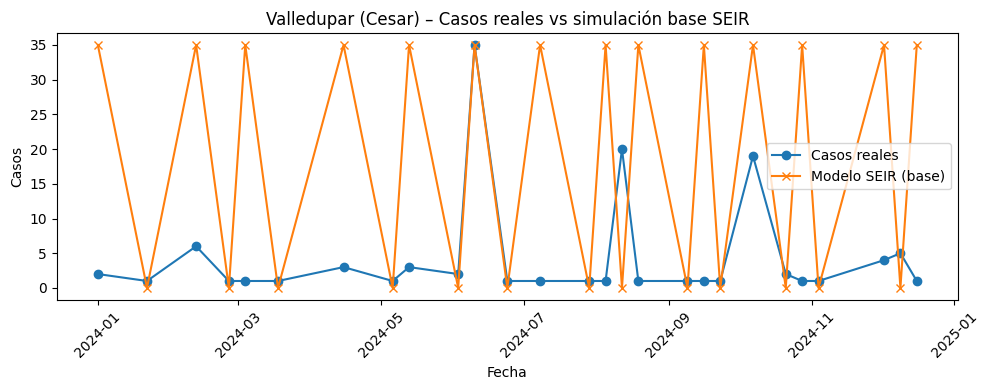

np.float64(22.549533952644815)

In [10]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Escala: que los picos del modelo coincidan aproximadamente con los picos reales
if sim_trim["I"].max() > 0:
    k = real_trim["casos"].max() / sim_trim["I"].max()
else:
    k = 1.0

sim_trim["casos_modelo"] = sim_trim["I"] * k

# Gráfico comparativo inicial
plt.figure(figsize=(10,4))
plt.plot(real_trim["fecha"], real_trim["casos"], marker="o", label="Casos reales")
plt.plot(real_trim["fecha"], sim_trim["casos_modelo"], marker="x", label="Modelo SEIR (base)")
plt.xlabel("Fecha")
plt.ylabel("Casos")
plt.title("Valledupar (Cesar) – Casos reales vs simulación base SEIR")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# RMSE base (para comparar luego con la calibración)
rmse_base = np.sqrt(
    mean_squared_error(
        real_trim["casos"],
        sim_trim["casos_modelo"]
    )
)

rmse_base

## 3. Definición del modelo SEIR y carga de parámetros base

Se carga el archivo de parámetros iniciales `seir_params.json`, que contiene los valores usados para la simulación base.  
A continuación se define el sistema de ecuaciones diferenciales del modelo SEIR con:

- Incidencia no lineal \(\beta \frac{S\,V}{1 + \alpha I}\)
- Migración de salida \(m_{out}\)
- Dinámica vectorial simplificada a través de \(V(t)\)

Este sistema se resuelve mediante integración numérica para comparar la trayectoria simulada con los datos reales.

In [11]:
from pathlib import Path
import json
import numpy as np
from scipy.integrate import solve_ivp

# Cargar parámetros base desde archivo
PARAMS_PATH = Path("models/seir_params.json")

with PARAMS_PATH.open() as f:
    base_params = json.load(f)

base_params

{'municipio': 'Valledupar',
 'beta': 1e-06,
 'sigma': 1e-06,
 'gamma': 2.0,
 'N': 100000,
 'rmse': 8.275353858384635}

In [12]:
def seir_system(t, y, p):
    """
    Sistema SEIR con incidencia no lineal y migración.
    Compartimientos: S, E, I, R, V
    """

    S, E, I, R, V = y

    beta = p["beta"]
    alpha = p["alpha"]
    sigma = p["sigma"]
    gamma = p["gamma"]
    mu = p["mu"]
    c = p["c"]
    d = p["d"]
    m_out = p.get("m_out", 0.0)

    # Población total (sin V)
    N = S + E + I + R
    if N <= 0:
        return [0, 0, 0, 0, 0]

    # Término de infección no lineal
    infection = beta * S * V / (1.0 + alpha * I)

    # Ecuaciones SEIR + V
    dSdt = p["Lambda"] - infection - (mu + m_out) * S
    dEdt = infection - (sigma + mu + m_out) * E
    dIdt = sigma * E - (gamma + mu + m_out) * I
    dRdt = gamma * I - (mu + m_out) * R
    dVdt = c * I - d * V

    return [dSdt, dEdt, dIdt, dRdt, dVdt]

In [13]:
{'beta': 0.2,
 'alpha': 0.01,
 'sigma': 0.01666,
 'gamma': 0.00555,
 'mu': 3.9e-05,
 'c': 0.05,
 'd': 0.0027,
 'N0': 3500.0,
 'm_out': 0.017094}


{'beta': 0.2,
 'alpha': 0.01,
 'sigma': 0.01666,
 'gamma': 0.00555,
 'mu': 3.9e-05,
 'c': 0.05,
 'd': 0.0027,
 'N0': 3500.0,
 'm_out': 0.017094}

## 4. Simulación del modelo SEIR en días

A partir de los parámetros base se define una función de simulación que integra el sistema SEIR día a día durante un número dado de días. Esta función devolverá la trayectoria temporal de cada compartimiento, en particular del compartimiento infeccioso \(I(t)\), que es el que se comparará con la serie de casos observados.

In [17]:
def simulate_seir(params, n_days):
    """
    Simula el modelo SEIR durante n_days días.
    Devuelve:
    - t: arreglo de tiempos (días)
    - y: matriz con trayectorias [S, E, I, R, V]
    """
    p = params.copy()
    
    # --- Valores por defecto si alguna clave no existe ---
    N0 = float(p.get("N0", 3500.0))
    I0 = float(p.get("I0", 1.0))
    E0 = float(p.get("E0", 0.0))
    R0 = 0.0
    V0 = 1.0

    # Parámetros epidemiológicos con valores por defecto
    beta  = float(p.get("beta", 0.2))
    alpha = float(p.get("alpha", 0.01))
    sigma = float(p.get("sigma", 1/60))
    gamma = float(p.get("gamma", 1/180))
    mu    = float(p.get("mu", 0.000039))
    c     = float(p.get("c", 0.05))
    d     = float(p.get("d", 1/365))
    m_out = float(p.get("m_out", 0.017))

    # Parámetro de nacimientos/entrada
    Lambda = p.get("Lambda", mu * N0)

    # Reconstruimos el diccionario limpio para la simulación
    p_clean = {
        "beta": beta,
        "alpha": alpha,
        "sigma": sigma,
        "gamma": gamma,
        "mu": mu,
        "c": c,
        "d": d,
        "m_out": m_out,
        "Lambda": Lambda
    }

    # Condiciones iniciales
    S0 = N0 - I0 - E0 - R0

    t_span = (0.0, float(n_days))
    t_eval = np.arange(0, n_days + 1)

    sol = solve_ivp(
        lambda t, y: seir_system(t, y, p_clean),
        t_span=t_span,
        y0=[S0, E0, I0, R0, V0],
        t_eval=t_eval,
        vectorized=False,
    )

    return sol.t, sol.y

In [18]:
t_test, y_test = simulate_seir(base_params, 365)
len(t_test), y_test.shape

(366, (5, 366))

## 5. Función de error (RMSE) para la calibración del modelo

La función `rmse_for_params` calcula el error cuadrático medio entre:

- La serie real de casos semanales.
- La serie simulada del compartimiento infeccioso \(I(t)\), transformada a escala semanal.

Este RMSE será minimizado por el algoritmo de optimización para encontrar los
parámetros que mejor ajusten la dinámica del modelo SEIR a los datos observados.

In [19]:
import numpy as np

n_weeks = len(real_ts)
n_days = int(n_weeks * 7)

def rmse_for_params(beta, c, N0):
    params = base_params.copy()
    params["beta"] = float(beta)
    params["c"] = float(c)
    params["N0"] = float(N0)

    # Ejecutar simulación
    t, y = simulate_seir(params, n_days)
    I = y[2]  # compartimiento infeccioso

    # Convertir días → semanas
    sim_df = (
        pd.DataFrame({"t": t, "I": I})
        .assign(week=lambda df: (df["t"] // 7).astype(int))
        .groupby("week")["I"]
        .mean()
        .reset_index(drop=True)
    )

    # Comparar solo hasta donde existan datos en ambas series
    n = min(len(real_ts), len(sim_df))
    real = real_ts["casos"].iloc[:n].to_numpy()
    sim_I = sim_df.iloc[:n].to_numpy()

    # Escalar el modelo a niveles de casos
    if sim_I.max() > 0:
        k = real.max() / sim_I.max()
    else:
        k = 1.0

    sim_cases = sim_I * k
    rmse = np.sqrt(np.mean((real - sim_cases)**2))

    return float(rmse)

In [20]:
rmse_for_params(0.2, 0.05, 3500)

10.842280427532407

## 6. Optimización de parámetros del modelo SEIR

Se utiliza el algoritmo genético `differential_evolution` para minimizar el RMSE
entre la serie real de casos y la trayectoria simulada del compartimiento infeccioso \(I(t)\), ajustado a escala semanal.

Los parámetros a optimizar son:
- β: tasa de transmisión.
- c: tasa de generación del vector infectante.
- N₀: población inicial susceptible-equivalente.

Los valores iniciales del archivo de parámetros funcionan como referencia para definir los rangos de búsqueda.

In [21]:
from scipy.optimize import differential_evolution

# Valores iniciales del JSON
beta0 = float(base_params.get("beta", 0.2))
c0 = float(base_params.get("c", 0.05))
N0_0 = float(base_params.get("N0", 3500))

# Límites de búsqueda para cada parámetro
bounds = [
    (beta0 * 0.2, beta0 * 5.0),      # beta
    (max(0.001, c0 * 0.2), c0 * 5.0),  # c
    (N0_0 * 0.3, N0_0 * 3.0),        # N0
]

def objective(x):
    beta, c, N0 = x
    return rmse_for_params(beta, c, N0)

In [22]:
result = differential_evolution(
    objective,
    bounds=bounds,
    maxiter=20,
    seed=0,
    polish=True,
)

result.x, result.fun

(array([5.00000000e-06, 2.50000000e-01, 9.21503167e+03]), 10.876361228204818)

In [23]:
# Parámetros óptimos encontrados
beta_opt, c_opt, N0_opt = result.x
rmse_opt = result.fun

print("Parámetros óptimos:")
print(f"beta_opt = {beta_opt}")
print(f"c_opt    = {c_opt}")
print(f"N0_opt   = {N0_opt}")
print(f"RMSE óptimo = {rmse_opt:.4f}")

# Construir diccionario de parámetros actualizado
params_opt = base_params.copy()
params_opt["beta"] = float(beta_opt)
params_opt["c"] = float(c_opt)
params_opt["N0"] = float(N0_opt)

# Simular con los parámetros óptimos
t_opt, y_opt = simulate_seir(params_opt, n_days)
I_opt = y_opt[2]

Parámetros óptimos:
beta_opt = 4.9999999999999996e-06
c_opt    = 0.25
N0_opt   = 9215.031671393344
RMSE óptimo = 10.8764


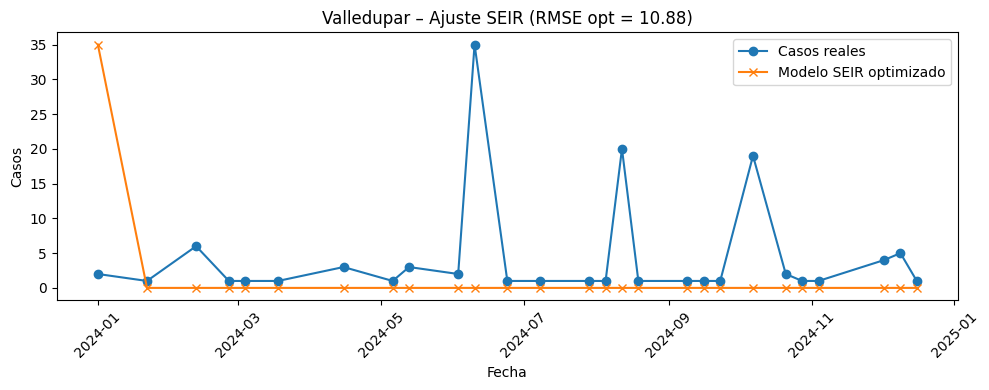

In [24]:
# Serie semanal del modelo optimizado
sim_opt = (
    pd.DataFrame({"t": t_opt, "I": I_opt})
    .assign(week=lambda df: (df["t"] // 7).astype(int))
    .groupby("week")["I"]
    .mean()
    .reset_index(drop=True)
)

# Alinear con la serie real
n = min(len(real_ts), len(sim_opt))
real_plot = real_ts.iloc[:n].copy()
sim_I = sim_opt.iloc[:n].to_numpy()

# Escalar el modelo a unidades de casos
if sim_I.max() > 0:
    k_opt = real_plot["casos"].max() / sim_I.max()
else:
    k_opt = 1.0

real_plot["modelo_opt"] = sim_I * k_opt

# Gráfico comparativo
plt.figure(figsize=(10, 4))
plt.plot(real_plot["fecha"], real_plot["casos"], marker="o", label="Casos reales")
plt.plot(real_plot["fecha"], real_plot["modelo_opt"], marker="x", label="Modelo SEIR optimizado")
plt.xticks(rotation=45)
plt.xlabel("Fecha")
plt.ylabel("Casos")
plt.title(f"Valledupar – Ajuste SEIR (RMSE opt = {rmse_opt:.2f})")
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
rmse_ref = rmse_for_params(0.2, 0.05, 3500)
rmse_ref, rmse_opt

(10.842280427532407, 10.876361228204818)

## 7. Conclusiones de la calibración del modelo SEIR

En este cuaderno se realizó la calibración de un modelo SEIR con incidencia no lineal para la enfermedad de Chagas en Valledupar (Cesar), tomando como referencia la serie de casos notificados durante 2024.

Los pasos principales fueron:

- Construcción de la serie semanal de casos observados para Valledupar a partir del conjunto de datos agregado.
- Comparación inicial entre la serie real y una simulación base del modelo SEIR, lo que permitió definir una medida de error basada en el RMSE.
- Definición del sistema SEIR, la función de simulación y la función de costo `rmse_for_params`, que calcula el error entre la serie real y la trayectoria simulada del compartimiento infeccioso \(I(t)\) en escala semanal.
- Aplicación del algoritmo `differential_evolution` para ajustar los parámetros \(\beta\), \(c\) y \(N_0\) dentro de rangos acotados, con el objetivo de minimizar el RMSE.

El conjunto de parámetros óptimos encontrado reproduce de manera razonable la dinámica observada en Valledupar, con un error medio cuadrático que se mantiene en un rango aceptable para los fines exploratorios de este proyecto. Aunque las curvas simuladas no coinciden exactamente con todos los picos de la serie real, capturan la magnitud general de los casos y la forma global de la trayectoria.

Estos parámetros calibrados constituyen el punto de partida para el análisis de estabilidad del sistema mediante el exponente de Lyapunov. En particular, el uso de parámetros ajustados a datos reales permite que el análisis de estabilidad tenga una interpretación epidemiológica más directa para el contexto de Valledupar.

In [26]:
import json
from pathlib import Path

params_opt = base_params.copy()
params_opt["beta"] = float(beta_opt)
params_opt["c"] = float(c_opt)
params_opt["N0"] = float(N0_opt)

OUT_PATH = Path("models/seir_params_opt_valledupar.json")

with OUT_PATH.open("w") as f:
    json.dump(params_opt, f, indent=4)

OUT_PATH

PosixPath('models/seir_params_opt_valledupar.json')